# Problem Set 2: Geospacial Maps #
Author: Christa Renee M. Chinjen  
GitHub: https://github.com/cmchinjen  
Date: May 2025  

In [5]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import contextily as ctx
import mapclassify
from matplotlib.lines import Line2D
from shapely.geometry import Point  
from scipy.io import loadmat

data_path = "/Users/christareneechinjen/Desktop/Econ 138/problem set 2 data//"

A global file path `data_path` for data files is defined.

---
## 01 | Hydrodams in South Africa 
Figure 2, using the population density instead of the river gradient, from: Mettetal, E. (2019). Irrigation dams, water and infant mortality: Evidence from South Africa. *Journal of Development Economics*, 138, 17-40. 

In [8]:
sa_boundary_gdf = gpd.read_file(data_path + "/01 south africa/SA_MDB_Local_Municipal_Boundary_2018/MDB_Local_Municipal_Boundary_2018.shp")
dams_df = pd.read_excel(data_path + "/01 south africa/Dams_south_africa.xlsx")  
persons_df = pd.read_csv(data_path + "/01 south africa/census-1996-person-v1.3.csv")

The following data is loaded:
- `sa_boundary_gdf` - shp file for South Africa boundaries
- `dams_df` - dam locations in South Africa
- `persons_df` - results of the 1996 South Africa census to be used for population data

In [10]:
print(sa_boundary_gdf.columns)
print(persons_df.columns)
print(sa_boundary_gdf['PROVINCE'].value_counts())
print(persons_df['province'].value_counts())

Index(['FID', 'OBJECTID', 'PROVINCE', 'CATEGORY', 'CAT2', 'CAT_B', 'MUNICNAME',
       'NAMECODE', 'MAP_TITLE', 'DISTRICT', 'DISTRICT_N', 'DATE', 'Shape__Are',
       'Shape__Len', 'geometry'],
      dtype='object')
Index(['province', 'district', 'dccode', 'newla', 'hhnumber', 'personno',
       'hhrecord', 'urban', 'insttype', 'sex', 'age', 'relship', 'marstau',
       'race', 'languag1', 'languag2', 'religion', 'birthcou', 'citizenc',
       'citizeno', 'citizenr', 'migworke', 'tempresi', 'usualdis', 'movedy2',
       'moveddis', 'disablec', 'sight', 'hearing', 'physical', 'mental',
       'motheral', 'fatheral', 'chilborn', 'childliv', 'agefrstb', 'bornlast',
       'school', 'qualfld', 'study', 'quallev', 'deducode', 'econactt',
       'worktime', 'wmployme', 'occupat', 'lstwrk1', 'industr', 'workingd',
       'income', 'pespweig', 'hhid'],
      dtype='object')
PROVINCE
KZN    44
EC     33
NC     26
WC     25
LIM    22
FS     19
NW     18
MP     17
GT      9
Name: count, dtype: in

Inspecting the data, the shapefile and population data contains a column for provinces, but with different values. 

In [17]:
# create a dictionary that maps province codes to abbreviated names
sa_province_map = {
    1: "WC", 
    2: "EC",
    3: "NC",
    4: "FS",
    5: "KZN",
    6: "NW",
    7: "GT",
    8: "MP",
    9: "LIM"
}

# apply the dictionary 
persons_df['province'] = persons_df['province'].replace(sa_province_map)

sa_provinces = set(persons_df['province']).intersection(sa_boundary_gdf['PROVINCE'])
print(sa_provinces)

{'NC', 'EC', 'FS', 'KZN', 'LIM', 'NW', 'MP', 'GT', 'WC'}


A dictionary `sa_province_map` is created to map `province` codes in `persons_df` to the abbreviated province names used in `sa_boundary_gdf`. The values of the provinces codes are derived from https://catalog.ihsn.org/index.php/catalog/2864/datafile/F1.

In [20]:
# group by province and sum the weights
pop_per_province = persons_df.groupby('province', as_index=False)['pespweig'].sum()
pop_per_province.columns = ['province', 'population']
print(pop_per_province)

  province   population
0       EC  6301971.558
1       FS  2633408.602
2       GT  7348071.424
3      KZN  8417422.639
4      LIM  4927336.231
5       MP  2797692.079
6       NC   840662.169
7       NW  3355012.267
8       WC  3957322.295


This groups the data by `province` and calculates the total population for each province by summing the expansion weights (`pespweig`) within each group. It then creates a new DataFrame `pop_per_province` with provinces and their corresponding population totals.

In [23]:
# merge population data into shapefile by province
sa_with_pop = sa_boundary_gdf.merge(
    pop_per_province,
    how='left',
    left_on='PROVINCE',
    right_on='province'
)

# calculate area (in square km) 
sa_with_pop['area_km2'] = sa_with_pop.geometry.to_crs(epsg=32735).area / 10**6

# calculate population density
sa_with_pop['pop_density'] = sa_with_pop['population'] / sa_with_pop['area_km2']

This merges the population data with the province shapefile into `sa_with_pop`, calculates the area of each province in square kilometers `area_km2` using a suitable coordinate reference system, and then computes the population density `pop_density` by dividing the population by the area for each province.

In [26]:
def dms_to_dd(deg, minutes, seconds): 
    return deg + (minutes / 60) + (seconds / 3600)

# use negative sign for southern hemisphere (latitude)
dams_df['lat_dd'] = -dms_to_dd(dams_df['Latitude deg'], dams_df['Lat min'], dams_df['Lat sec'])
dams_df['lon_dd'] = dms_to_dd(dams_df['Longitude deg'], dams_df['Long min'], dams_df['Long sec'])

# create dam gdf in EPSG:4326
dams_gdf = gpd.GeoDataFrame(
    dams_df,
    geometry=gpd.points_from_xy(dams_df['lon_dd'], dams_df['lat_dd']),
    crs='EPSG:4326'
)

# convert pop gdf to EPSG:4326 for matching
sa_with_pop_4326 = sa_with_pop.to_crs(epsg=4326)

This converts dam location coordinates from degrees-minutes-seconds (DMS) to decimal degrees (DD), accounting for the southern hemisphere by negating latitude values. It then creates a GeoDataFrame of dam locations and reprojects both the dam data and census shapefile to the same coordinate system (EPSG:4326). 

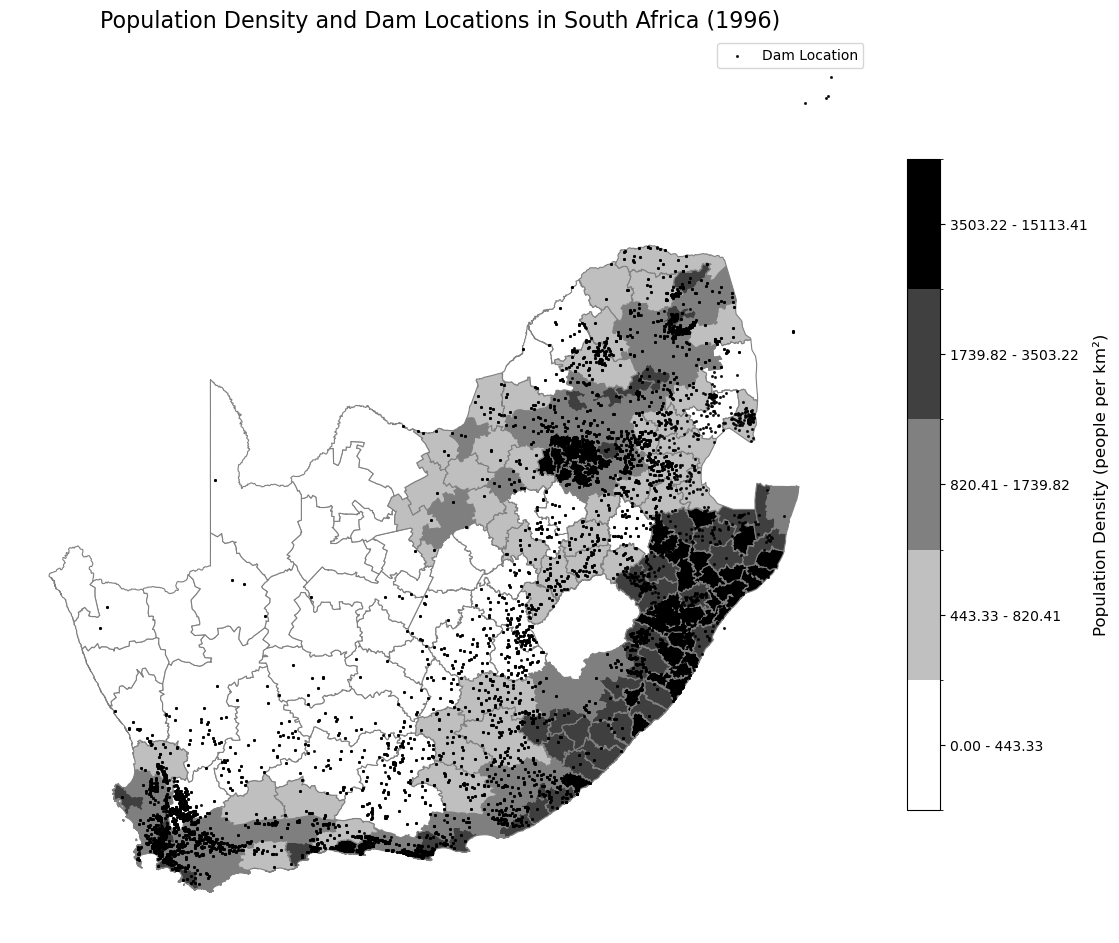

In [188]:
# classify population density with mapclassify quantiles
classifier = mapclassify.Quantiles(sa_with_pop_4326['pop_density'], k=5)
bins = [0] + list(classifier.bins)  # Add zero for start

# choose colormap
cmap = plt.cm.binary

# plot map without legend
fig, ax = plt.subplots(figsize=(12, 12))
sa_with_pop_4326.plot(
    column='pop_density',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='gray',
    scheme='user_defined',
    classification_kwds={'bins': bins[1:]},  # exclude 0 for classification
    k=5,
    legend=False,
    ax=ax
)

# overlay dams
dams_gdf.plot(ax=ax, color='black', markersize=1.5, label='Dam Location', alpha=0.8)

# add title and dams legend
ax.set_title('Population Density and Dam Locations in South Africa (1996)', fontsize=16)
ax.legend()

# create a colorbar manually
norm = mpl.colors.BoundaryNorm(bins, cmap.N)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for colorbar

# add colorbar with bin labels
cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.04, ticks=[(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)])

# label ticks with intervals
labels = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins)-1)]
cbar.ax.set_yticklabels(labels)
cbar.set_label('Population Density (people per km²)', fontsize=12)

ax.set_axis_off()
plt.show()

This visualizes population density and dam locations in South Africa using a choropleth map. First, it classifies population density into five quantile-based bins using `mapclassify.Quantiles`, then customizes the classification to exclude the lowest bin (often near zero) to avoid a washed-out map. The data is plotted using the `Grays` colormap where higher densities are shaded darker, and dam locations are overlaid as black points. A custom colorbar is manually constructed to match the classification bins and provide clear, labeled intervals for interpreting population density levels.

---
## 02 | Ethiopian Population density and ERSS Sample Villages
Figure 4 from: Fried, S., & Lagakos, D. (2021). Rural electrification, migration and structural transformation: Evidence from Ethiopia. *Regional Science and Urban Economics*, 91, 103625.

In [51]:
eth_boundary_gdf = gpd.read_file(data_path + "/02 ethiopia/Ethiopia_AdminBoundaries-shp/Ethiopia_AdminBoundaries.shp")
eth_generators_gdf = gpd.read_file(data_path + "/02 ethiopia/Ethiopia_-_generators-shp/Ethiopia_-_generators.shp")
eth_roads_gdf = gpd.read_file(data_path + "/02 ethiopia/ethiopia_roads/Ethiopia_Roads.shp")
eth_elec_gdf = gpd.read_file(data_path + "/02 ethiopia/ethiopia-electricity-transmission-network/Ethiopia Electricity Transmission Network.shp")
erss = pd.read_csv(data_path + "/02 ethiopia/ETH_2011_ERSS_v02_M_CSV/pub_eth_householdgeovariables_y1.csv")
cod = pd.read_csv(data_path + "/02 ethiopia/cod_population_admin3.csv")

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(
/var/folders/hg/mwfmq9xd5z177hn9h7346d400000gn/T/ipykernel_97985/3902672937.py:6: DtypeWarning: Columns (8,9,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  cod = pd.read_csv(data_path + "/02 ethiopia/cod_population_admin3.csv")


The following data is loaded:
- `eth_boundary_gdf` - shp file for Ethiopia boundaries
- `eth_generators_gdf` - shp file for generator locations in Ethiopia
- `eth_roads_gdf` - shp file for major roads in Ethiopia
- `eth_elec_gdf` - shp file for electricity networks in Ethiopia
- `erss` - locations of the wordas sampled in the Ethiopian Rural Socioeconomic Survey (ERSS)
- `cod` - population data from a Common Operational Dataset (COD)

In [53]:
eth_pop = cod.loc[cod['Country'] == 'Ethiopia'].copy()

First, extract all rows from the cod DataFrame where the country is Ethiopia and store them in a new, independent DataFrame called `eth_pop`.

In [59]:
print(eth_boundary_gdf.columns)
print(eth_pop.columns)
print(eth_boundary_gdf['REGIONNAME'].value_counts())
print(eth_pop['ADM1_NAME'].value_counts())

Index(['OBJECTID', 'REGIONNAME', 'ZONENAME', 'WOREDANO_', 'WOREDANAME',
       'GlobalID', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')
Index(['ISO3', 'Country', 'ADM1_PCODE', 'ADM1_NAME', 'ADM2_PCODE', 'ADM2_NAME',
       'ADM3_PCODE', 'ADM3_NAME', 'ADM4_PCODE', 'ADM4_NAME',
       'Population_group', 'Gender', 'Age_range', 'Age_min', 'Age_max',
       'Population', 'Reference_year', 'Source', 'Contributor'],
      dtype='object')
REGIONNAME
Oromia              254
SNNPR               136
Amhara              128
Somali               53
Tigray               34
Afar                 32
Beneshangul Gumu     21
Gambela              13
Addis Ababa          10
Dire Dawa             2
Hareri                1
Name: count, dtype: int64
ADM1_NAME
Oromia                 17136
Amhara                 11169
SNNP                    7497
Somali                  5049
Tigray                  4488
South West Ethiopia     2397
Afar                    1989
Sidama                  1887
Ben

Inspecting the data, the shapefile and population data contains a column for region, but with different values. 

In [72]:
# create a dictionary that corrects region names in eth_pop
eth_region_map = {
    'SNNP': 'SNNPR',
    'Benishangul Gumz': 'Beneshangul Gumu',
    'Harari': 'Hareri'
}

# apply the mapping to the popu dataset
eth_pop['ADM1_NAME'] = eth_pop['ADM1_NAME'].replace(eth_region_map)

common_values = set(eth_pop['ADM1_NAME']).intersection(eth_boundary_gdf['REGIONNAME'])
print(common_values)

{'Somali', 'Afar', 'Oromia', 'SNNPR', 'Amhara', 'Tigray', 'Hareri', 'Addis Ababa', 'Beneshangul Gumu', 'Gambela', 'Dire Dawa'}


A dictionary `eth_region_map` is created to match some region names used in `eth_pop` to `sa_boundary_gdf`. Note that the regions "South West Ethiopia" and "Sidama" were not in the population dataset and are therefore omitted in calculating population density.

In [75]:
# aggregate population to region
eth_pop = eth_pop.groupby("ADM1_NAME", as_index=False)["Population"].sum()

# merge population data into shapefile by region
eth_with_pop = eth_boundary_gdf.merge(
    eth_pop,
    how='left',
    left_on='REGIONNAME',
    right_on='ADM1_NAME'
)

# calculate area (in square km) 
eth_with_pop['area_km2'] = eth_with_pop.geometry.to_crs(epsg=3857).area / 10**6

# calculate population density
eth_with_pop['pop_density'] = eth_with_pop['Population'] / eth_with_pop['area_km2']

This aggregates population data by administrative region, merges it with the shapefile of Ethiopian regions into `eth_with_pop`, computes the area of each region in square kilometers `area_km2`, and then calculates population density `pop_density` by dividing population by area.

In [78]:
# drop rows without GPS coordinates
geo_vars = geo_vars.dropna(subset=["LAT_DD_MOD", "LON_DD_MOD"])

# convert to gdf
geo_vars['geometry'] = geo_vars.apply(lambda row: Point(row['LON_DD_MOD'], row['LAT_DD_MOD']), axis=1)
geo_vars_gdf = gpd.GeoDataFrame(geo_vars, geometry='geometry', crs="EPSG:4326")

# spatial join to identify which woreda each household belongs to 
sampled = gpd.sjoin(geo_vars_gdf, eth_boundary_gdf, how="inner", predicate='within')

# get unique sampled woredas
sampled_woredas = sampled[['WOREDANO_', 'WOREDANAME', 'ZONENAME', 'REGIONNAME']].drop_duplicates()
print(sampled_woredas)

     WOREDANO_       WOREDANAME       ZONENAME REGIONNAME
0       010101   Tahtay Adiyabo  North Western     Tigray
12      010102   Laelay Adiyabo  North Western     Tigray
24      010103     Medebay Zana  North Western     Tigray
48      010105  Asgede Tsimbila  North Western     Tigray
60      010106         Tselemti  North Western     Tigray
...        ...              ...            ...        ...
3620    120301           Godere      Mezhenger    Gambela
3644    120208          Mengesh      Mezhenger    Gambela
3668    120207            Etang         Agnuak    Gambela
3692    130101            Harar         Hareri     Hareri
3800    150102        Dire Dawa      Dire Dawa  Dire Dawa

[263 rows x 4 columns]


To plot the woredas sampled in the ERSS, rows without valid GPS coordinates are filtered out. Then, a GeoDataFrame is created by converting latitude and longitude into spatial Point geometries. Then, a spatial join is performed to match each household to the woreda it falls within and extracts a list of unique woredas that were sampled in the survey.

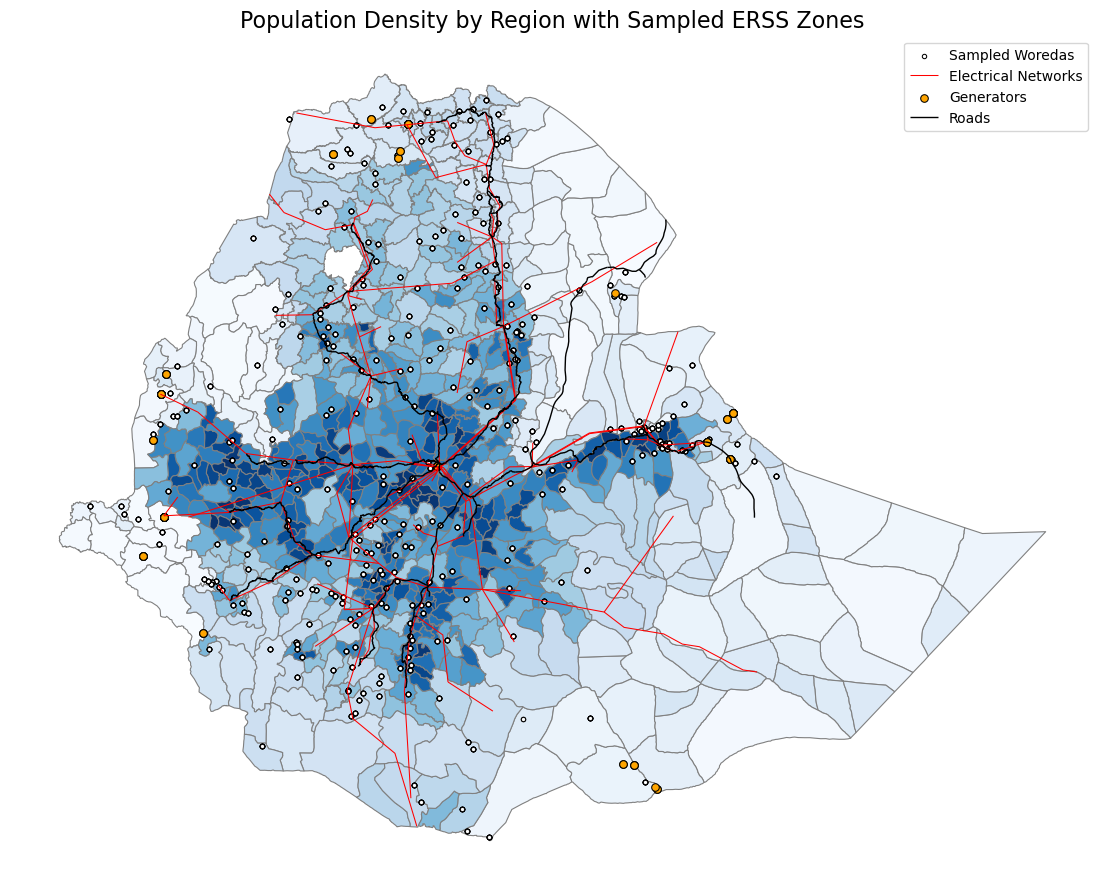

In [81]:
fig, ax = plt.subplots(figsize=(14, 14))

# choropleth for population density
plot = eth_with_pop.plot(
    column='pop_density',
    cmap='Blues',
    linewidth=0.8,
    edgecolor='gray',
    legend=True,
    ax=ax
)

# plot: sampled woredas 
geo_vars_gdf.plot(ax=ax, color='white', markersize=10, edgecolor='black', linewidth=0.75, label='Sampled Woredas')

# plot: electrical network lines
eth_elec_gdf.plot(ax=ax, color='red', linewidth=0.75, label='Electrical Networks')

# plot: generators 
eth_generators_gdf.plot(ax=ax, color='orange', markersize=30, edgecolor='black', linewidth=0.75, label='Generators')

# plot: roads
eth_roads_gdf.plot(ax=ax, color='black', linewidth=1, label='Roads')

# title and legend
ax.set_title("Population Density by Region with Sampled ERSS Zones", fontsize=16)
ax.axis('off')
ax.legend(title="") 

plt.show()

### 03 | Roadmap of Vietnam
Figure 10 from: Balboni, C. (2025). In harm's way? infrastructure investments and the persistence of coastal cities. *American Economic Review*, 115(1), 77-116. 

In [107]:
viet_boundary_gdf = gpd.read_file(data_path + '/03 vietnam/gadm41_VNM_shp/gadm41_VNM_0.shp')
viet_roads_gdf = gpd.read_file(data_path + '/03 vietnam/vietnam-latest-free.shp/gis_osm_roads_free_1.shp')

The following data is loaded:
- `viet_boundary_gdf` - shp file for Vietnam boundaries
- `viet_roads_gdf` - shp file for Vietnam roads

In [109]:
print(viet_roads_gdf.columns)
print(viet_roads_gdf['fclass'].unique())

Index(['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed',
       'layer', 'bridge', 'tunnel', 'geometry'],
      dtype='object')
['footway' 'residential' 'primary' 'tertiary' 'primary_link' 'secondary'
 'trunk' 'service' 'motorway' 'motorway_link' 'unclassified'
 'secondary_link' 'path' 'pedestrian' 'tertiary_link' 'track' 'steps'
 'trunk_link' 'cycleway' 'living_street' 'track_grade1' 'track_grade5'
 'track_grade4' 'track_grade3' 'unknown' 'track_grade2' 'busway'
 'bridleway']


Inspecting the data, the road shapefile has a column `fclass` that classifies roads by type. 

In [111]:
def categorize_road(fclass):
    if fclass in ['motorway']:
        return 'Freeway'
    elif fclass in ['trunk', 'trunk_link']:
        return 'Major Roads'
    elif fclass in ['primary', 'primary_link']:
        return 'Minor Roads'
    elif fclass in ['secondary', 'secondary_link']:
        return 'Other Roads'
    else:
        return None

viet_roads_gdf['road_category'] = viet_roads_gdf['fclass'].apply(categorize_road)
viet_roads_gdf = viet_roads_gdf.dropna(subset=['road_category'])

freeway_gdf = viet_roads_gdf[viet_roads_gdf['road_category'] == 'Freeway']
major_gdf = viet_roads_gdf[viet_roads_gdf['road_category'] == 'Major Roads']
minor_gdf = viet_roads_gdf[viet_roads_gdf['road_category'] == 'Minor Roads']
others_gdf = viet_roads_gdf[viet_roads_gdf['road_category'] == 'Other Roads']

This defines a function `categorize_road` that groups road types into four categories: **Freeway, Major Roads, Minor Roads**, and **Other Roads**. It applies this function to the `fclass` column of the `viet_roads_gdf` GeoDataFrame, creating a new column called `road_category`. Any rows that don’t fit into these categories are dropped. Finally, this filters the GeoDataFrame into four separate GeoDataFrames based on the road category.

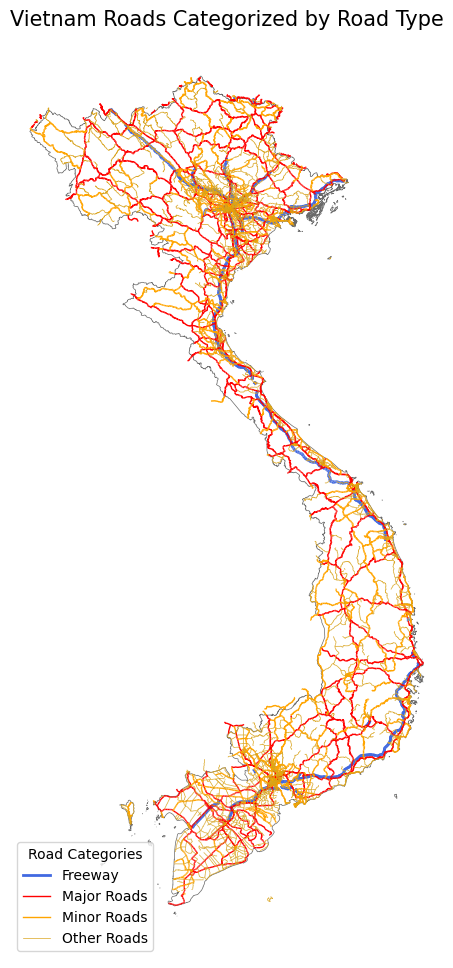

In [144]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot base map
viet_boundary_gdf.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.5)

# Plot roads by category
freeway_gdf.plot(ax=ax, color='royalblue', linewidth=2, zorder=4)
major_gdf.plot(ax=ax, color='red', linewidth=1, zorder=6)
minor_gdf.plot(ax=ax, color='orange', linewidth=1, zorder=7)
others_gdf.plot(ax=ax, color='goldenrod', linewidth=0.5, zorder=8)

# Legend
legend_elements = [
    Line2D([0], [0], color='royalblue', lw=2, label='Freeway'),
    Line2D([0], [0], color='red', lw=1, label='Major Roads'),
    Line2D([0], [0], color='orange', lw=1, label='Minor Roads'),
    Line2D([0], [0], color='goldenrod', lw=0.5, label='Other Roads')
]
ax.legend(handles=legend_elements, title="Road Categories", loc='lower left')

# Final touches
ax.set_axis_off()
plt.title('Vietnam Roads Categorized by Road Type', fontsize=15)
plt.show()

This code generates a detailed map of Vietnam, displaying different categories of roads using distinct colors and line widths. It plots the country boundary first, then overlays roads categorized as Freeway, Major Roads, Minor Roads, and Other Roads using their respective GeoDataFrames. A legend explains the color coding for each road type, and the map is presented without axis labels for a cleaner visual. The result is a clear and stylized visualization of Vietnam’s road network.

### 04 | Brazil's Capital and Main Road Infrastructure
Figure 1 from: Morten, M., & Oliveira, J. (2024). The effects of roads on trade and migration: Evidence from a planned capital city. *American Economic Journal: Applied Economics*, 16(2), 389-421.

In [162]:
brazil_gdf = gpd.read_file(data_path + '/04 brazil/Data/GIS_data/outline/outline_mainland_only_prj.shp')
brazil_cities = gpd.read_file(data_path + '/04 brazil/Data/GIS_data/cities/brazil_capital_cities_prj.shp')
brazil_highways = gpd.read_file(data_path + '/04 brazil/Data/GIS_data/roads/2000/highways_2000_prj.shp')
mst = gpd.read_file(data_path + '/04 brazil/Data/GIS_data/mst/mst_pie_prj.shp')

The following data is loaded:
- `brazil_gdf`- shp file for Brazil boundaries
- `brazil_cities` shp file for Brazil's capital cities
- `brazil_highways`- shp file for Brazil highways
- `mst` - shp file for minimum spanning tree (mst) of Brazil's road network

In [165]:
print(brazil_highways.columns)

Index(['OBJECTID', 'id_trecho_', 'vl_br', 'sg_uf', 'nm_tipo_tr', 'sg_tipo_tr',
       'desc_coinc', 'vl_codigo', 'ds_local_i', 'ds_local_f', 'vl_km_inic',
       'vl_km_fina', 'vl_extensa', 'ds_sup_fed', 'ds_obra', 'ds_coinc',
       'ds_tipo_ad', 'ds_ato_leg', 'est_coinc', 'sup_est_co', 'ds_jurisdi',
       'ds_superfi', 'ds_legenda', 'sg_legenda', 'leg_multim', 'versao_snv',
       'id_versao', 'marcador', 'ICS', 'Shape_Leng', 'LABEL', 'dm_anlys',
       'dm_anlys_p', 'dm_radial', 'geometry'],
      dtype='object')


Inspecting the data, the shapefile for highways distinguishes between radial and non-radial highways. 

In [174]:
# convert radial flag to boolean
brazil_highways['is_radial'] = brazil_highways['dm_radial'] == 1

# split into two subsets
radial = brazil_highways[brazil_highways['is_radial']]
non_radial = brazil_highways[~brazil_highways['is_radial']]

This converts the radial flag to boolean and splits the gdf into two subses: `radial` and `non-radial` for mapping later.

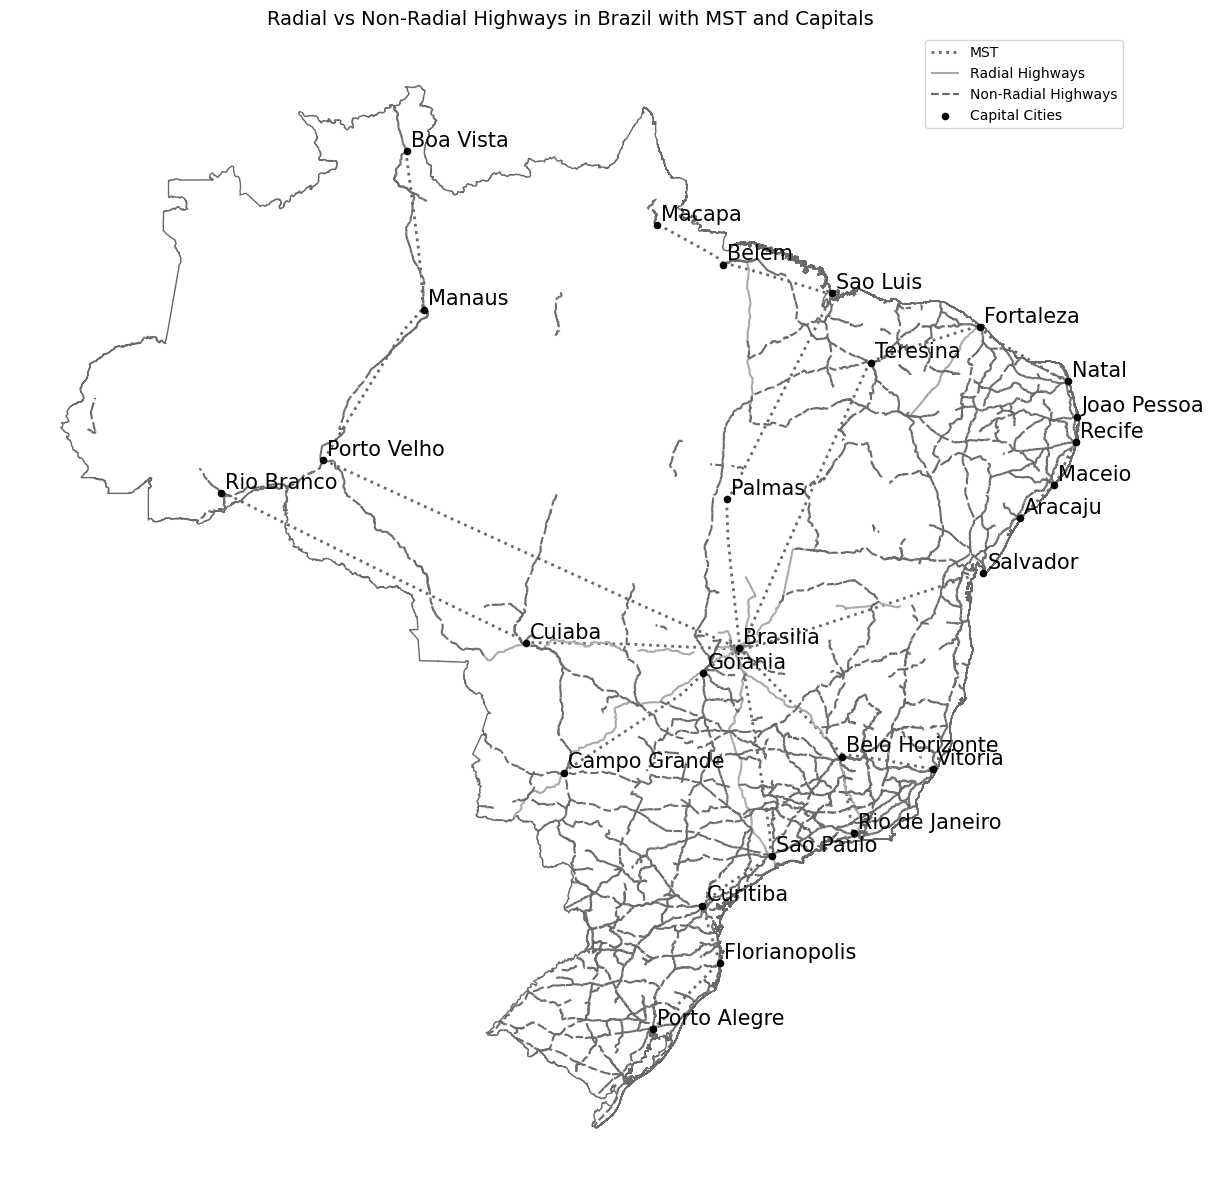

In [180]:
fig, ax = plt.subplots(figsize=(14, 12))

# plot base map 
brazil_gdf.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=1)

# plot MST
mst.plot(ax=ax, color='dimgray', linewidth=2, linestyle='dotted', label='MST')

# plot highways
radial.plot(ax=ax, color='darkgray', linewidth=1.5, linestyle='solid', label='Radial Highways')
non_radial.plot(ax=ax, color='dimgray', linewidth=1.5, linestyle='dashed', label='Non-Radial Highways')

# plot capital cities
brazil_cities.plot(ax=ax, color='black', markersize=20, marker='o', label='Capital Cities', zorder=5)

# add capital names
for idx, row in brazil_cities.iterrows():
    ax.annotate(row['CITY_NAME'], xy=(row.geometry.x, row.geometry.y), xytext=(3, 3),
                textcoords="offset points", fontsize=15, color='black')

# plot with legend, title, and formatting
ax.legend()
ax.set_title("Radial vs Non-Radial Highways in Brazil with MST and Capitals", fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

This creates a detailed map of Brazil showing its mesoregions, highways, minimum spanning tree (MST) of the road network, and capital cities. It plots the MST as dotted lines, distinguishes radial and non-radial highways with different line styles, and marks capital cities with labeled points. Each map layer is styled for clarity, and a legend and title are added for interpretation. The map is finalized with axis removal and tight layout formatting for clean visualization.